In [21]:
# Install TensorFlow
# !pip install -q tensorflow

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0


In [0]:
# More imports
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization # LeakyReLU is commonly used in GANs
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import pdb

# Load Data

In [0]:
mnist = tf.keras.datasets.mnist

# Data Preprocessing

In [0]:
# Center data around 0, such that it is from -1 to +1 for better training
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.0 * 2 - 1
X_test = X_test / 255.0 * 2 - 1

In [0]:
# Flatten data to be N x D
N, H, W = X_train.shape
D = H * W
X_train = X_train.reshape(-1, D)
X_test = X_test.reshape(-1, D)

In [0]:
# Latent space dimensionality used for noise used by generator
latent_dim = 100 # hyperparameter - may choose as you like

# Build Model

## Build Generator ANN

In [0]:

def build_generator(laten_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x) # Inputs are between -1 and +1 so need a tanh

  model = Model(i, x)

  return model

## Build Discriminator ANN

In [0]:

def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)

  return model

## Compile Models

### Generator

In [0]:
# Build generator
generator = build_generator(latent_dim)

# Create input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator which gets mapped to create an image
img = generator(z)


### Discriminator

In [0]:
# Build discriminator
discriminator = build_discriminator(D)

discriminator.compile(optimizer=Adam(0.0002, 0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Freeze weights of discriminator so that it doesn't get trained
discriminator.trainable = False 

# True output is fake, but they are labelled as real
fake_predictions = discriminator(img)


### Combined Model

In [0]:
# Build combined model
# Input is the input to the generator, output is the output of the discriminator
combined_model = Model(z, fake_predictions)

combined_model.compile(optimizer=Adam(0.0002, 0.5),
                      loss='binary_crossentropy',
                       metrics=['accuracy'])

# Train GAN Combined Model

## Set Up

In [0]:
batch_size = 64
epochs = 35000
sample_period = 200 # Period for sampling and saving images

# Batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Losses
g_losses = []
d_losses = []

# Accuracies
g_accs= []
d_accs = []

# Folder for images
image_path = 'GAN_images'
if not os.path.exists(image_path):
  os.makedirs(image_path)

In [0]:
def sample_images(epoch):
  '''
  Creates a sample GAN image and saves it to folder.
  '''
  # Create noise
  rows = 5
  cols = 5
  noise = np.random.randn(rows * cols, latent_dim)

  # Generator images
  imgs = generator.predict(noise)

  # Rescale images
  imgs = 0.5 * imgs + 0.5

  # Plot images to figure
  fig, ax = plt.subplots(rows, cols)
  img_idx = 0;
  for i in range(rows):
    for j in range(cols):
      ax[i,j].imshow(imgs[img_idx].reshape(H, W), cmap='gray')
      ax[i,j].axis('off')
      img_idx += 1
  fig.savefig(image_path + '/%d.png' % epoch)
  plt.close()

## Training

In [34]:
for epoch in range(epochs):
  # Discriminator training

  # Get random image batch of images
  img_idx = np.random.randint(0, X_train.shape[0], batch_size)
  real_imgs = X_train[img_idx]

  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # Train discriminator on batch with real images - get discriminator loss and accuracy
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)

  # Train discriminator on batch with fake images - get discriminator loss and accuracy
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)

  # Calculator overall loss and accuracy
  d_loss = (d_loss_real + d_loss_fake) / 2
  d_acc = (d_acc_real + d_acc_fake) / 2

  # Generator training

  # Train combined model on batch - get generator loss
  noise = np.random.randn(batch_size, latent_dim)
  g_loss, g_acc = combined_model.train_on_batch(noise, ones)

  # Save discriminator and generator losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  # Save discriminator and generator accuracies
  d_accs.append(d_acc)
  g_accs.append(g_acc)

  # If every 100th epoch then print results
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, \
          d_loss: {d_loss:.2f}, \
          d_acc: {d_acc:.2f}, \
          g_loss: {g_loss:.2f}, \
          g_acc: {g_acc:.2f}")
    
  # If every image sample epoch then save image samples
  if epoch % sample_period ==  100:
    sample_images(epoch)

# Save last image
sample_images(epoch)

epoch: 1/35000,           d_loss: 1.08,           d_acc: 0.48,           g_loss: 0.93,           g_acc: 0.19
epoch: 101/35000,           d_loss: 0.01,           d_acc: 1.00,           g_loss: 4.39,           g_acc: 0.00
epoch: 201/35000,           d_loss: 0.10,           d_acc: 0.95,           g_loss: 3.83,           g_acc: 0.00
epoch: 301/35000,           d_loss: 0.69,           d_acc: 0.65,           g_loss: 1.72,           g_acc: 0.25
epoch: 401/35000,           d_loss: 0.71,           d_acc: 0.41,           g_loss: 0.68,           g_acc: 0.67
epoch: 501/35000,           d_loss: 0.67,           d_acc: 0.46,           g_loss: 0.67,           g_acc: 0.62
epoch: 601/35000,           d_loss: 0.65,           d_acc: 0.50,           g_loss: 0.68,           g_acc: 0.50
epoch: 701/35000,           d_loss: 0.66,           d_acc: 0.51,           g_loss: 0.70,           g_acc: 0.41
epoch: 801/35000,           d_loss: 0.63,           d_acc: 0.66,           g_loss: 0.75,           g_acc: 0.22
epo

# Evaluate Model

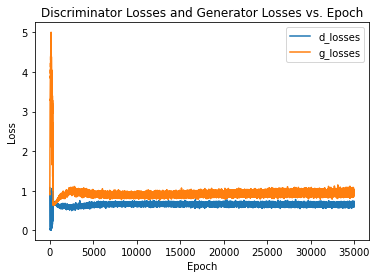

In [35]:
# Plot the loss
plt.plot(d_losses, label='d_losses')
plt.plot(g_losses, label='g_losses')
plt.title("Discriminator Losses and Generator Losses vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

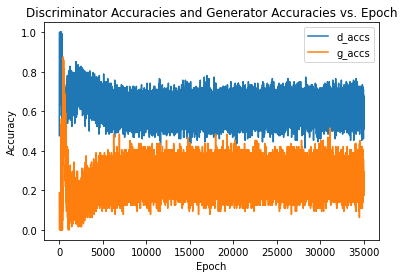

In [36]:
# Plot the accuracies
plt.plot(d_accs, label='d_accs')
plt.plot(g_accs, label='g_accs')
plt.title("Discriminator Accuracies and Generator Accuracies vs. Epoch")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

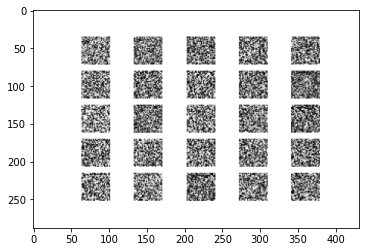

In [37]:
# Image from near the start of training
from skimage.io import imread
img_start_of_training = imread(image_path + '/%d.png' % 100)
plt.imshow(img_start_of_training)

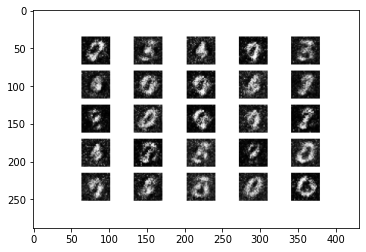

In [38]:
# Generated image after more training
img_start_of_training = imread(image_path + '/%d.png' % 1100)
plt.imshow(img_start_of_training)

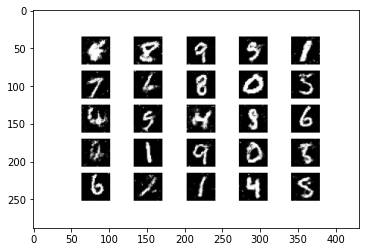

In [39]:
# Generated image after even more training
img_start_of_training = imread(image_path + '/%d.png' % 20100)
plt.imshow(img_start_of_training)

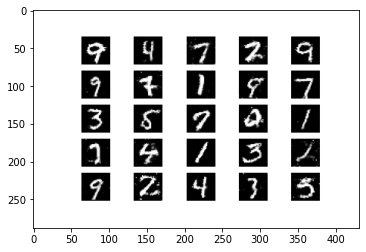

In [40]:
# Generated image after a lot of training
img_start_of_training = imread(image_path + '/%d.png' % epoch)
plt.imshow(img_start_of_training)